## Function

In [1]:
from math import *

import numpy as np
import scipy
from PIL import ImageTk, Image
import cv2
from scipy import ndimage
from scipy import signal
import os

In [2]:
def ridge_segment(im, blksze, thresh):  # img,16,0.1 把图像分成16x16的像素块

    rows, cols = im.shape

    im = normalise(im)  # normalise to get zero mean and unit standard deviation 
    # imshow("norm",im)

    new_rows = int(blksze * np.ceil((np.float64(rows)) / (np.float64(blksze))))
    new_cols = int(blksze * np.ceil((np.float64(cols)) / (np.float64(blksze))))

    padded_img = np.zeros((new_rows, new_cols))
    stddevim = np.zeros((new_rows, new_cols))

    padded_img[0:rows][:, 0:cols] = im

    for i in range(0, new_rows, blksze):
        for j in range(0, new_cols, blksze):
            block = padded_img[i:i + blksze][:, j:j + blksze]

            stddevim[i:i + blksze][:, j:j + blksze] = np.std(block) * np.ones(block.shape)

    stddevim = stddevim[0:rows][:, 0:cols]

    mask = stddevim > thresh

    mean_val = np.mean(im[mask])

    std_val = np.std(im[mask])

    normim = (im - mean_val) / (std_val)
    # imshow("norm",normim)

    return (normim, mask)

In [3]:
def ridge_orient(im, gradientsigma, blocksigma, orientsmoothsigma): #方向场估计
    rows, cols = im.shape
    # Calculate image gradients.
    sze = np.fix(6 * gradientsigma)
    if np.remainder(sze, 2) == 0:
        sze = sze + 1

    gauss = cv2.getGaussianKernel(int(sze), gradientsigma)
    f = gauss * gauss.T

    fy, fx = np.gradient(f)  # Gradient of Gaussian

    # Gx = ndimage.convolve(np.double(im),fx);
    # Gy = ndimage.convolve(np.double(im),fy);

    Gx = signal.convolve2d(im, fx, mode='same')
    Gy = signal.convolve2d(im, fy, mode='same')

    Gxx = np.power(Gx, 2)
    Gyy = np.power(Gy, 2)
    Gxy = Gx * Gy

    # Now smooth the covariance data to perform a weighted summation of the data.

    sze = np.fix(6 * blocksigma)

    gauss = cv2.getGaussianKernel(int(sze), blocksigma)
    f = gauss * gauss.T

    Gxx = ndimage.convolve(Gxx, f)
    Gyy = ndimage.convolve(Gyy, f)
    Gxy = 2 * ndimage.convolve(Gxy, f)

    # Analytic solution of principal direction
    denom = np.sqrt(np.power(Gxy, 2) + np.power((Gxx - Gyy), 2)) + np.finfo(float).eps

    sin2theta = Gxy / denom  # Sine and cosine of doubled angles
    cos2theta = (Gxx - Gyy) / denom

    if orientsmoothsigma:
        sze = np.fix(6 * orientsmoothsigma)
        if np.remainder(sze, 2) == 0:
            sze = sze + 1
        gauss = cv2.getGaussianKernel(int(sze), orientsmoothsigma)
        f = gauss * gauss.T
        cos2theta = ndimage.convolve(cos2theta, f)  # Smoothed sine and cosine of
        sin2theta = ndimage.convolve(sin2theta, f)  # doubled angles

    orientim = np.pi / 2 + np.arctan2(sin2theta, cos2theta) / 2
    return orientim

In [4]:
def ridge_freq(im, mask, orient, blksze, windsze, minWaveLength, maxWaveLength): #频率场估计
    rows, cols = im.shape
    freq = np.zeros((rows, cols))

    for r in range(0, rows - blksze, blksze):
        for c in range(0, cols - blksze, blksze):
            blkim = im[r:r + blksze][:, c:c + blksze]
            blkor = orient[r:r + blksze][:, c:c + blksze]

            freq[r:r + blksze][:, c:c + blksze] = frequest(blkim, blkor, windsze, minWaveLength, maxWaveLength)

    freq = freq * mask
    freq_1d = np.reshape(freq, (1, rows * cols))
    ind = np.where(freq_1d > 0)

    ind = np.array(ind)
    ind = ind[1, :]

    non_zero_elems_in_freq = freq_1d[0][ind]

    meanfreq = np.mean(non_zero_elems_in_freq)
    medianfreq = np.median(non_zero_elems_in_freq)  # does not work properly
    return freq, meanfreq

In [5]:
def ridge_filter(im, orient, freq, kx, ky): #滤波
    angleInc = 3
    im = np.double(im)
    rows, cols = im.shape
    newim = np.zeros((rows, cols))

    freq_1d = np.reshape(freq, (1, rows * cols))
    ind = np.where(freq_1d > 0)

    ind = np.array(ind)
    ind = ind[1, :]

    # Round the array of frequencies to the nearest 0.01 to reduce the
    # number of distinct frequencies we have to deal with.

    non_zero_elems_in_freq = freq_1d[0][ind]
    non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100

    unfreq = np.unique(non_zero_elems_in_freq)

    # Generate filters corresponding to these distinct frequencies and
    # orientations in 'angleInc' increments.

    sigmax = 1 / unfreq[0] * kx
    sigmay = 1 / unfreq[0] * ky

    sze = int(np.round(3 * np.max([sigmax, sigmay])))

    x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

    reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
        2 * np.pi * unfreq[0] * x)  # this is the original gabor filter

    filt_rows, filt_cols = reffilter.shape

    angleRange = int(180 / angleInc)

    gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

    for o in range(0, angleRange):
        # Generate rotated versions of the filter.  Note orientation
        # image provides orientation *along* the ridges, hence +90
        # degrees, and imrotate requires angles +ve anticlockwise, hence
        # the minus sign.

        rot_filt = scipy.ndimage.rotate(reffilter, -(o * angleInc + 90), reshape=False)
        gabor_filter[o] = rot_filt

    # Find indices of matrix points greater than maxsze from the image
    # boundary

    maxsze = int(sze)

    temp = freq > 0
    validr, validc = np.where(temp)

    temp1 = validr > maxsze
    temp2 = validr < rows - maxsze
    temp3 = validc > maxsze
    temp4 = validc < cols - maxsze

    final_temp = temp1 & temp2 & temp3 & temp4

    finalind = np.where(final_temp)

    # Convert orientation matrix values from radians to an index value
    # that corresponds to round(degrees/angleInc)

    maxorientindex = np.round(180 / angleInc)
    orientindex = np.round(orient / np.pi * 180 / angleInc)

    # do the filtering

    for i in range(0, rows):
        for j in range(0, cols):
            if orientindex[i][j] < 1:
                orientindex[i][j] = orientindex[i][j] + maxorientindex
            if orientindex[i][j] > maxorientindex:
                orientindex[i][j] = orientindex[i][j] - maxorientindex
    finalind_rows, finalind_cols = np.shape(finalind)
    sze = int(sze)
    for k in range(0, finalind_cols):
        r = validr[finalind[0][k]]
        c = validc[finalind[0][k]]

        img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

        newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

    return newim

In [6]:
def normalise(img): #归一化
    normed = (img - np.mean(img)) / (np.std(img))
    return normed

In [7]:
def frequest(im, orientim, windsze, minWaveLength, maxWaveLength): #一维正弦波两相邻峰值之间的平均像素数
    rows, cols = np.shape(im)

    # Find mean orientation within the block. This is done by averaging the
    # sines and cosines of the doubled angles before reconstructing the
    # angle again.  This avoids wraparound problems at the origin.

    cosorient = np.mean(np.cos(2 * orientim))
    sinorient = np.mean(np.sin(2 * orientim))
    orient = atan2(sinorient, cosorient) / 2

    # Rotate the image block so that the ridges are vertical

    # ROT_mat = cv2.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)
    # rotim = cv2.warpAffine(im,ROT_mat,(cols,rows))
    rotim = scipy.ndimage.rotate(im, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3, mode='nearest')

    # Now crop the image so that the rotated image does not contain any
    # invalid regions.  This prevents the projection down the columns
    # from being mucked up.

    cropsze = int(np.fix(rows / np.sqrt(2)))
    offset = int(np.fix((rows - cropsze) / 2))
    rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

    # Sum down the columns to get a projection of the grey values down
    # the ridges.

    proj = np.sum(rotim, axis=0)
    dilation = scipy.ndimage.grey_dilation(proj, windsze, structure=np.ones(windsze))

    temp = np.abs(dilation - proj)

    peak_thresh = 2

    maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
    maxind = np.where(maxpts)

    rows_maxind, cols_maxind = np.shape(maxind)

    # Determine the spatial frequency of the ridges by divinding the
    # distance between the 1st and last peaks by the (No of peaks-1). If no
    # peaks are detected, or the wavelength is outside the allowed bounds,
    # the frequency image is set to 0

    if cols_maxind < 2:
        freqim = np.zeros(im.shape)
    else:
        NoOfPeaks = cols_maxind
        waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
        if waveLength >= minWaveLength and waveLength <= maxWaveLength:
            freqim = 1 / np.double(waveLength) * np.ones(im.shape)
        else:
            freqim = np.zeros(im.shape)

    return freqim

In [8]:
def VThin(image, array):
    # h = image.height
    # w = image.width
    h, w = image.shape
    NEXT = 1
    for i in range(h):
        for j in range(w):
            if NEXT == 0:
                NEXT = 1
            else:
                M = image[i, j - 1] + image[i, j] + image[i, j + 1] if 0 < j < w - 1 else 1
                if image[i, j] == 0 and M != 0:
                    a = [0] * 9
                    for k in range(3):
                        for l in range(3):
                            if -1 < (i - 1 + k) < h and -1 < (j - 1 + l) < w and image[i - 1 + k, j - 1 + l] == 255:
                                a[k * 3 + l] = 1
                    sum = a[0] * 1 + a[1] * 2 + a[2] * 4 + a[3] * 8 + a[5] * 16 + a[6] * 32 + a[7] * 64 + a[8] * 128
                    image[i, j] = array[sum] * 255
                    if array[sum] == 1:
                        NEXT = 0
    return image

def HThin(image, array):
    # h = image.height
    # w = image.width
    h, w = image.shape
    NEXT = 1
    for j in range(w):
        for i in range(h):
            if NEXT == 0:
                NEXT = 1
            else:
                M = image[i - 1, j] + image[i, j] + image[i + 1, j] if 0 < i < h - 1 else 1
                if image[i, j] == 0 and M != 0:
                    a = [0] * 9
                    for k in range(3):
                        for l in range(3):
                            if -1 < (i - 1 + k) < h and -1 < (j - 1 + l) < w and image[i - 1 + k, j - 1 + l] == 255:
                                a[k * 3 + l] = 1
                    sum = a[0] * 1 + a[1] * 2 + a[2] * 4 + a[3] * 8 + a[5] * 16 + a[6] * 32 + a[7] * 64 + a[8] * 128
                    image[i, j] = array[sum] * 255
                    if array[sum] == 1:
                        NEXT = 0
    return image

## Main

In [9]:
# from tkinter import *
from math import *

import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import ImageTk, Image
import cv2
from scipy import ndimage
from scipy import signal
from skimage.filters import threshold_otsu

np.set_printoptions(threshold=np.inf, linewidth=850)
path = r'D:\desktop\1\z\feature\imgprocess\sample_notebook\1__M_Left_index_finger.BMP'

## Choose image

In [10]:

img_path = path
if img_path:
    img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_COLOR)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转灰度图

    threshold_global_otsu = threshold_otsu(img) #确定阈值
    im_front = np.asarray((img > threshold_global_otsu), dtype='uint8') # 0和1，区分背景和指纹
    im = img.copy() * im_front
    newim1 = cv2.equalizeHist(im)
    newim2 = cv2.equalizeHist(img)

    rows, cols = np.shape(newim2)
    aspect_ratio = np.double(rows) / np.double(cols)

    new_rows = 225  # randomly selected number
    new_cols = new_rows / aspect_ratio

    oriimg = cv2.resize(newim2, (int(new_cols), int(new_rows)))

## Image Enhancement

In [11]:
blksze = 16
thresh = 0.1
normim, mask = ridge_segment(oriimg, blksze, thresh)  # normalise the image and find a ROI

In [12]:
gradientsigma = 1
blocksigma = 7
orientsmoothsigma = 7
orientim = ridge_orient(normim, gradientsigma, blocksigma, orientsmoothsigma)  # find orientation of every pixel

blksze = 38
windsze = 5
minWaveLength = 5
maxWaveLength = 15
freq, medfreq = ridge_freq(normim, mask, orientim, blksze, windsze, minWaveLength,
                            maxWaveLength)  # find the overall frequency of ridges

freq = medfreq * mask
kx = 0.65
ky = 0.65
newim = ridge_filter(normim, orientim, freq, kx, ky)  # create gabor filter and do the actual filtering

im_front = np.asarray((newim > -3), dtype='uint8')
enhimg1 = im_front * 255

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
im1 = cv2.morphologyEx(im_front, cv2.MORPH_OPEN, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
im2 = cv2.morphologyEx(im1, cv2.MORPH_CLOSE, kernel)
enhimg2 = im2 * 255

## Thinning


In [13]:
array = [0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, \
            1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, \
            0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, \
            1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, \
            1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
            1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, \
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
            0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, \
            1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, \
            0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, \
            1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, \
            1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
            1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, \
            1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, \
            1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]

# img = img.tolist()
# img.copyTo(iXihua)
# thiimg = oriimg.copy()
thiimg1 = enhimg1.copy()
thiimg2 = enhimg2.copy()
for i in range(10):
    # VThin(thiimg, array)
    # HThin(thiimg, array)
    VThin(thiimg1, array)
    HThin(thiimg1, array)
    VThin(thiimg2, array)
    HThin(thiimg2, array)

C:\Users\Czz\AppData\Local\Temp\ipykernel_3144\3563380520.py:11: RuntimeWarning: overflow encountered in scalar add
  M = image[i, j - 1] + image[i, j] + image[i, j + 1] if 0 < j < w - 1 else 1
C:\Users\Czz\AppData\Local\Temp\ipykernel_3144\3563380520.py:34: RuntimeWarning: overflow encountered in scalar add
  M = image[i - 1, j] + image[i, j] + image[i + 1, j] if 0 < i < h - 1 else 1


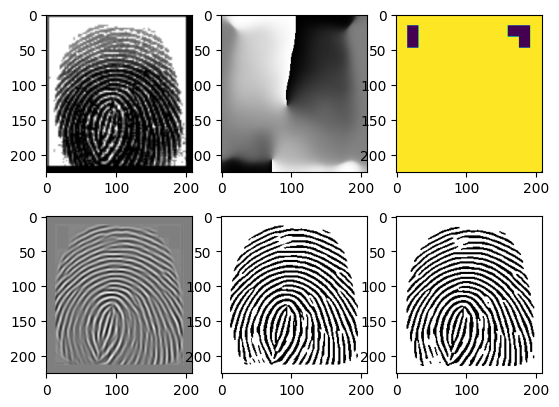

In [ ]:

fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(oriimg, cmap = plt.cm.gray)
axs[0, 1].imshow(orientim, cmap = plt.cm.gray)
axs[0, 2].imshow(freq, cmap = plt.cm.gray)
axs[1, 0].imshow(newim, cmap = plt.cm.gray)
axs[1, 1].imshow(im_front, cmap = plt.cm.gray)
axs[1, 2].imshow(enhimg2, cmap = plt.cm.gray)
plt.savefig('sample.png')
plt.show()
plt.imsave('oriimg.png', oriimg, cmap = plt.cm.gray)
plt.imsave('orientim.png', orientim, cmap = plt.cm.gray)
plt.imsave('freq.png', freq, cmap = plt.cm.gray)
plt.imsave('newim.png', newim, cmap = plt.cm.gray)
plt.imsave('im_front.png', im_front, cmap = plt.cm.gray)
plt.imsave('enhimg2.png', enhimg2, cmap = plt.cm.gray)

## pipeline

In [27]:
def process(outputpath, filepath=False, img=None):
    img_path = filepath
    if img is None:
        if img_path:
            img = cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_COLOR)
            if len(img.shape) > 2:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转灰度图

    rows, cols = np.shape(img)
    aspect_ratio = np.double(rows) / np.double(cols)

    new_cols = 384  # randomly selected number
    new_rows = new_cols * aspect_ratio

    oriimg = cv2.resize(img, (int(new_cols), int(new_rows)))
        
    blksze = 16
    thresh = 0.1
    normim, mask = ridge_segment(oriimg, blksze, thresh)  # normalise the image and find a ROI

    gradientsigma = 1
    blocksigma = 7
    orientsmoothsigma = 7
    orientim = ridge_orient(normim, gradientsigma, blocksigma, orientsmoothsigma)  # find orientation of every pixel

    blksze = 38
    windsze = 5
    minWaveLength = 5
    maxWaveLength = 15
    freq, medfreq = ridge_freq(normim, mask, orientim, blksze, windsze, minWaveLength,
                                maxWaveLength)  # find the overall frequency of ridges

    freq = medfreq * mask
    kx = 0.65
    ky = 0.65
    newim = ridge_filter(normim, orientim, freq, kx, ky)  # create gabor filter and do the actual filtering

    im_front = np.asarray((newim > -3), dtype='uint8')
    enhimg1 = im_front[14:398, :] * 255
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # im1 = cv2.morphologyEx(enhimg1, cv2.MORPH_OPEN, kernel)
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    # im2 = cv2.morphologyEx(im1, cv2.MORPH_CLOSE, kernel)
    cv2.imwrite(outputpath,enhimg1)
    print(outputpath)
    return enhimg1

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=850)
input_dir = r'D:\desktop\1\z\SOCOFing\Real/'
output_dir = r'D:\desktop\1\z\SOCOFing\cropped_images/'
err = []

In [ ]:
for _, _, filenames in os.walk(input_dir):
# 打印所有非目录文件名
    names = filenames
    
for i in names:
    try:
        process(str(output_dir+i), str(input_dir+i))
    except IndexError:
        err.append(str(input_dir + i + '\n'))

In [ ]:
for root, _, filenames in os.walk(output_dir):
    # 获取所有非目录文件名
    names = filenames

for i in names:
    img_path = os.path.join(root + i)
    img = cv2.cvtColor(cv2.imdecode(np.fromfile(img_path, dtype=np.uint8), cv2.IMREAD_COLOR), cv2.COLOR_BGR2GRAY)
    
    # 计算连通区域
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(img, connectivity=8)
    
    # 计算最大连通区域的面积（排除背景）
    max_area = max(stats[1:, cv2.CC_STAT_AREA])  # 排除背景区域
    total_area = img.shape[0] * img.shape[1]
    
    # 如果最大白色区域占比超过阈值，则认为图像存在大量空白
    if max_area / total_area > 0.9:
        err.append(str(input_dir + i + '\n'))

In [57]:
with open('errlist.txt', 'w+') as f:
    f.writelines(err)
print(len(err))

13


## ErrorProcess

In [66]:
import cv2
output_dir = r'D:\desktop\1\z\SOCOFing\cropped_images/'
from skimage.filters import threshold_otsu
import numpy as np

def run(file, output_dir=output_dir):
    im = cv2.imread(file)
    newim = im.copy()
    if len(im.shape) > 2: 
        newim = cv2.cvtColor(newim, cv2.COLOR_BGR2GRAY)
    threshold_global_otsu = threshold_otsu(newim) 
    im_front = np.asarray((newim > threshold_global_otsu), dtype='uint8') 
    im = newim.copy() * im_front
    newim1 = cv2.equalizeHist(im)
    newim2 = cv2.equalizeHist(newim)
    try:
        gray1 = process(str(output_dir + file.split('/')[-1].split('.')[0] + '_1.BMP'), img=newim1)
        gray2 = process(str(output_dir + file.split('/')[-1].split('.')[0] + '_2.BMP'), img=newim2)
        not_processed = process(str(output_dir + file.split('/')[-1].split('.')[0] + '_ori.BMP'), img=newim)
        img_add = cv2.addWeighted(gray1, 0.5, gray2, 0.5, 0)
        cv2.imwrite(str(output_dir + file.split('/')[-1].split('.')[0] + '.BMP'), img_add)
    except IndexError:
        try:
            process(str(output_dir + file.split('/')[-1].split('.')[0] + '.BMP'), img=newim2)
        except IndexError:
            process(str(output_dir + file.split('/')[-1].split('.')[0] + '.BMP'), img=newim1)

In [67]:
with open('errlist.txt', 'r') as f:
    for i in f.readlines():
        run(i.strip('\n'), r'D:\desktop\1\z\SOCOFing\sample\\')

D:\desktop\1\z\SOCOFing\sample\\127_1_1.BMP
D:\desktop\1\z\SOCOFing\sample\\127_1_2.BMP
D:\desktop\1\z\SOCOFing\sample\\127_1_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\127_2_1.BMP
D:\desktop\1\z\SOCOFing\sample\\127_2_2.BMP
D:\desktop\1\z\SOCOFing\sample\\127_2_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\127_4_1.BMP
D:\desktop\1\z\SOCOFing\sample\\127_4_2.BMP
D:\desktop\1\z\SOCOFing\sample\\127_4_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\154_9_1.BMP
D:\desktop\1\z\SOCOFing\sample\\154_9_2.BMP
D:\desktop\1\z\SOCOFing\sample\\154_9_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\16_9_1.BMP
D:\desktop\1\z\SOCOFing\sample\\16_9_2.BMP
D:\desktop\1\z\SOCOFing\sample\\16_9_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\207_4_1.BMP
D:\desktop\1\z\SOCOFing\sample\\207_4_2.BMP
D:\desktop\1\z\SOCOFing\sample\\207_4_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\212_10_1.BMP
D:\desktop\1\z\SOCOFing\sample\\212_10_2.BMP
D:\desktop\1\z\SOCOFing\sample\\212_10_ori.BMP


d:\anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


D:\desktop\1\z\SOCOFing\sample\\249_7.BMP
D:\desktop\1\z\SOCOFing\sample\\31_9_1.BMP
D:\desktop\1\z\SOCOFing\sample\\31_9_2.BMP
D:\desktop\1\z\SOCOFing\sample\\31_9_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\406_7_1.BMP
D:\desktop\1\z\SOCOFing\sample\\406_7_2.BMP
D:\desktop\1\z\SOCOFing\sample\\406_7_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\406_9_1.BMP
D:\desktop\1\z\SOCOFing\sample\\406_9_2.BMP
D:\desktop\1\z\SOCOFing\sample\\406_9_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\543_1_1.BMP
D:\desktop\1\z\SOCOFing\sample\\543_1_2.BMP
D:\desktop\1\z\SOCOFing\sample\\543_1_ori.BMP
D:\desktop\1\z\SOCOFing\sample\\543_4_1.BMP
D:\desktop\1\z\SOCOFing\sample\\543_4_2.BMP
D:\desktop\1\z\SOCOFing\sample\\543_4_ori.BMP


In [ ]:
output_dir = r'D:\desktop\1\z\SOCOFing\cropped_images/'
sample_dir = r'D:\desktop\1\z\SOCOFing\sample/'
sample1_dir = r'D:\desktop\1\z\SOCOFing\sample1/'

for dir1, _, filenames in os.walk(output_dir):
    names1 = filenames
    
for dir2, _, filenames in os.walk(sample_dir):
    names2 = filenames
    
comlist=[]
for i in names1:
    for j in names2:
        if i == j:
            img1 = cv2.cvtColor(cv2.imread(os.path.join(dir1, i)), cv2.COLOR_BGR2GRAY)
            img2 = cv2.cvtColor(cv2.imread(os.path.join(dir2, i)), cv2.COLOR_BGR2GRAY)
            img_add = cv2.addWeighted(img1, 0.6, img2, 0.4, 0)
            cv2.imwrite(str(sample1_dir + i.split('.')[0] + '.BMP'), img_add)